In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
from six.moves import xrange
import tensorflow as tf
print(tf.version.VERSION)
if tf.version.VERSION != '1.13.1':
    raise Exception('Wrong dependency for cleverhans')

from cleverhans.attacks import SaliencyMapMethod
from cleverhans.compat import flags
from cleverhans.dataset import MNIST
from cleverhans.loss import CrossEntropy
from cleverhans.utils import other_classes, set_log_level
from cleverhans.utils import pair_visual, grid_visual, AccuracyReport
from cleverhans.utils_tf import model_eval, model_argmax
from cleverhans.train import train
from cleverhans.model_zoo.basic_cnn import ModelBasicCNN

1.13.1


In [7]:
FLAGS = flags.FLAGS

VIZ_ENABLED = True
NB_EPOCHS = 6
BATCH_SIZE = 128
LEARNING_RATE = .001
SOURCE_SAMPLES = 10

In [8]:
def mnist_tutorial_jsma(train_start=0, train_end=60000, test_start=0,
                        test_end=10000, viz_enabled=VIZ_ENABLED,
                        nb_epochs=NB_EPOCHS, batch_size=BATCH_SIZE,
                        source_samples=SOURCE_SAMPLES,
                        learning_rate=LEARNING_RATE):
    """
    MNIST tutorial for the Jacobian-based saliency map approach (JSMA)
    :param train_start: index of first training set example
    :param train_end: index of last training set example
    :param test_start: index of first test set example
    :param test_end: index of last test set example
    :param viz_enabled: (boolean) activate plots of adversarial examples
    :param nb_epochs: number of epochs to train model
    :param batch_size: size of training batches
    :param nb_classes: number of output classes
    :param source_samples: number of test inputs to attack
    :param learning_rate: learning rate for training
    :return: an AccuracyReport object
    """
    # Object used to keep track of (and return) key accuracies
    report = AccuracyReport()

    # Set TF random seed to improve reproducibility
    tf.set_random_seed(1234)

    # Create TF session and set as Keras backend session
    sess = tf.Session()
    print("Created TensorFlow session.")

    set_log_level(logging.DEBUG)

    # Get MNIST test data
    mnist = MNIST(train_start=train_start, train_end=train_end,
                  test_start=test_start, test_end=test_end)
    x_train, y_train = mnist.get_set('train')
    x_test, y_test = mnist.get_set('test')

    # Obtain Image Parameters
    img_rows, img_cols, nchannels = x_train.shape[1:4]
    nb_classes = y_train.shape[1]

    # Define input TF placeholder
    x = tf.placeholder(tf.float32, shape=(None, img_rows, img_cols,
                                          nchannels))
    y = tf.placeholder(tf.float32, shape=(None, nb_classes))

    nb_filters = 64
    # Define TF model graph
    model = ModelBasicCNN('model1', nb_classes, nb_filters)
    preds = model.get_logits(x)
    loss = CrossEntropy(model, smoothing=0.1)
    print("Defined TensorFlow model graph.")

    ###########################################################################
    # Training the model using TensorFlow
    ###########################################################################

    # Train an MNIST model
    train_params = {
        'nb_epochs': nb_epochs,
        'batch_size': batch_size,
        'learning_rate': learning_rate
    }
    sess.run(tf.global_variables_initializer())
    rng = np.random.RandomState([2017, 8, 30])
    train(sess, loss, x_train, y_train, args=train_params, rng=rng)

    # Evaluate the accuracy of the MNIST model on legitimate test examples
    eval_params = {'batch_size': batch_size}
    accuracy = model_eval(sess, x, y, preds, x_test, y_test, args=eval_params)
    assert x_test.shape[0] == test_end - test_start, x_test.shape
    print('Test accuracy on legitimate test examples: {0}'.format(accuracy))
    report.clean_train_clean_eval = accuracy

    ###########################################################################
    # Craft adversarial examples using the Jacobian-based saliency map approach
    ###########################################################################
    print('Crafting ' + str(source_samples) + ' * ' + str(nb_classes - 1) +
          ' adversarial examples')

    # Keep track of success (adversarial example classified in target)
    results = np.zeros((nb_classes, source_samples), dtype='i')

    # Rate of perturbed features for each test set example and target class
    perturbations = np.zeros((nb_classes, source_samples), dtype='f')

    # Initialize our array for grid visualization
    grid_shape = (nb_classes, nb_classes, img_rows, img_cols, nchannels)
    grid_viz_data = np.zeros(grid_shape, dtype='f')

    # Instantiate a SaliencyMapMethod attack object
    jsma = SaliencyMapMethod(model, sess=sess)
    jsma_params = {'theta': 1., 'gamma': 0.1,
                   'clip_min': 0., 'clip_max': 1.,
                   'y_target': None}

    figure = None
    # Loop over the samples we want to perturb into adversarial examples
    for sample_ind in xrange(0, source_samples):
        print('--------------------------------------')
        print('Attacking input %i/%i' % (sample_ind + 1, source_samples))
        sample = x_test[sample_ind:(sample_ind + 1)]

        # We want to find an adversarial example for each possible target class
        # (i.e. all classes that differ from the label given in the dataset)
        current_class = int(np.argmax(y_test[sample_ind]))
        target_classes = other_classes(nb_classes, current_class)

        # For the grid visualization, keep original images along the diagonal
        grid_viz_data[current_class, current_class, :, :, :] = np.reshape(
            sample, (img_rows, img_cols, nchannels))

        # Loop over all target classes
        for target in target_classes:
            print('Generating adv. example for target class %i' % target)

            # This call runs the Jacobian-based saliency map approach
            one_hot_target = np.zeros((1, nb_classes), dtype=np.float32)
            one_hot_target[0, target] = 1
            jsma_params['y_target'] = one_hot_target
            adv_x = jsma.generate_np(sample, **jsma_params)

            # Check if success was achieved
            res = int(model_argmax(sess, x, preds, adv_x) == target)

            # Compute number of modified features
            adv_x_reshape = adv_x.reshape(-1)
            test_in_reshape = x_test[sample_ind].reshape(-1)
            nb_changed = np.where(adv_x_reshape != test_in_reshape)[0].shape[0]
            percent_perturb = float(nb_changed) / adv_x.reshape(-1).shape[0]

            # Display the original and adversarial images side-by-side
            if viz_enabled:
                figure = pair_visual(
                    np.reshape(sample, (img_rows, img_cols, nchannels)),
                    np.reshape(adv_x, (img_rows, img_cols, nchannels)), figure)

            # Add our adversarial example to our grid data
            grid_viz_data[target, current_class, :, :, :] = np.reshape(
                adv_x, (img_rows, img_cols, nchannels))

            # Update the arrays for later analysis
            results[target, sample_ind] = res
            perturbations[target, sample_ind] = percent_perturb

    print('--------------------------------------')

    # Compute the number of adversarial examples that were successfully found
    nb_targets_tried = ((nb_classes - 1) * source_samples)
    succ_rate = float(np.sum(results)) / nb_targets_tried
    print('Avg. rate of successful adv. examples {0:.4f}'.format(succ_rate))
    report.clean_train_adv_eval = 1. - succ_rate

    # Compute the average distortion introduced by the algorithm
    percent_perturbed = np.mean(perturbations)
    print('Avg. rate of perturbed features {0:.4f}'.format(percent_perturbed))

    # Compute the average distortion introduced for successful samples only
    percent_perturb_succ = np.mean(perturbations * (results == 1))
    print('Avg. rate of perturbed features for successful '
          'adversarial examples {0:.4f}'.format(percent_perturb_succ))

    # Close TF session
    sess.close()

    # Finally, block & display a grid of all the adversarial examples
    if viz_enabled:
        import matplotlib.pyplot as plt
        plt.close(figure)
        _ = grid_visual(grid_viz_data)

    return report


Created TensorFlow session.
Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Defined TensorFlow model graph.
Instructions for updating:
dim is deprecated, use axis instead
num_devices:  1


/home/lukec/workspace/cleverhans/cleverhans/utils_tf.py:628: UserWarning: No GPUS, running on CPU
  warnings.warn("No GPUS, running on CPU")
[INFO 2020-02-18 13:15:46,804 cleverhans] Epoch 0 took 46.32601881027222 seconds
[INFO 2020-02-18 13:16:33,155 cleverhans] Epoch 1 took 46.31192374229431 seconds
[INFO 2020-02-18 13:17:19,428 cleverhans] Epoch 2 took 46.23297452926636 seconds
[INFO 2020-02-18 13:18:05,728 cleverhans] Epoch 3 took 46.26096701622009 seconds
[INFO 2020-02-18 13:18:51,518 cleverhans] Epoch 4 took 45.752097845077515 seconds
[INFO 2020-02-18 13:19:37,336 cleverhans] Epoch 5 took 45.7790584564209 seconds
/home/lukec/workspace/cleverhans/cleverhans/attacks_tf.py:27: UserWarning: attacks_tf is deprecated and will be removed on 2019-07-18 or after. Code should import functions from their new locations directly.
  warnings.warn("attacks_tf is deprecated and will be removed on 2019-07-18"
[INFO 2020-02-18 13:19:38,030 cleverhans] Constructing new graph for attack SaliencyMapM

Test accuracy on legitimate test examples: 0.9934
Crafting 10 * 9 adversarial examples
--------------------------------------
Attacking input 1/10
Generating adv. example for target class 0


/home/lukec/workspace/cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_sum_v1 at 0x7fc6cd4419d8> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
/home/lukec/workspace/cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_max_v1 at 0x7fc6cd444730> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
/home/lukec/workspace/cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_any_v1 at 0x7fc6cd444c80> is deprecated. S

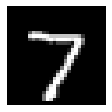

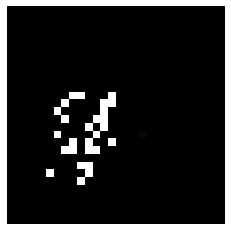

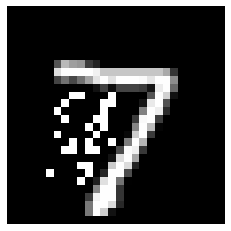

Generating adv. example for target class 1


/home/lukec/workspace/cleverhans/cleverhans/utils.py:169: UserWarning: `pair_visual` has moved to `cleverhans.plot.pyplot_image`. cleverhans.utils.pair_visual may be removed on or after 2019-04-24.
  warnings.warn("`pair_visual` has moved to `cleverhans.plot.pyplot_image`. "
/home/lukec/workspace/cleverhans/cleverhans/plot/pyplot_image.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  figure.add_subplot(1, 3, index + 1)


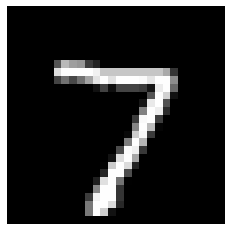

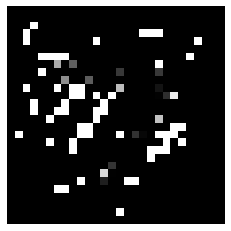

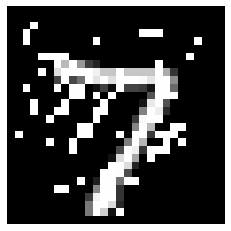

Generating adv. example for target class 2


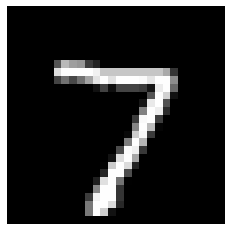

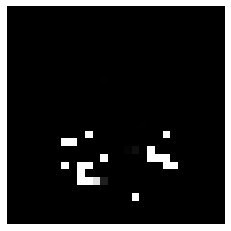

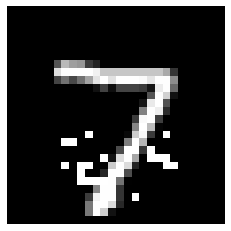

Generating adv. example for target class 3


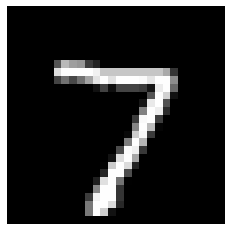

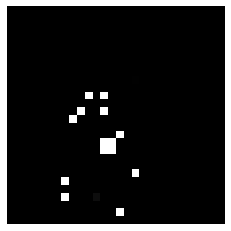

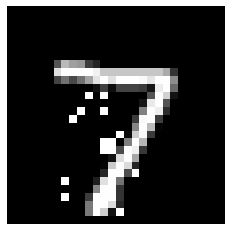

Generating adv. example for target class 4


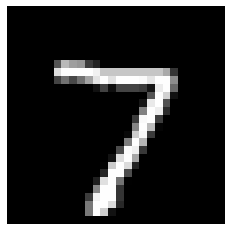

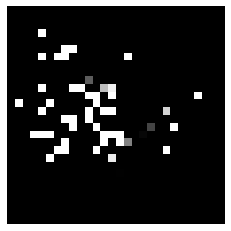

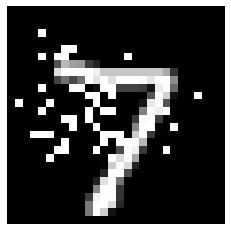

Generating adv. example for target class 5


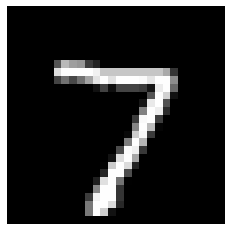

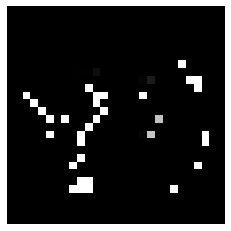

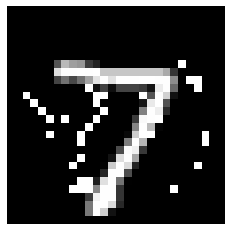

Generating adv. example for target class 6


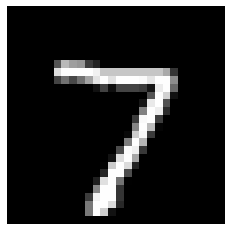

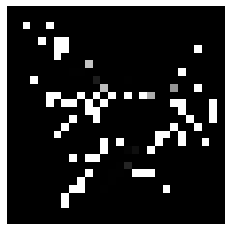

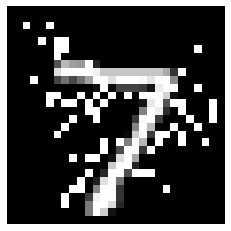

Generating adv. example for target class 8


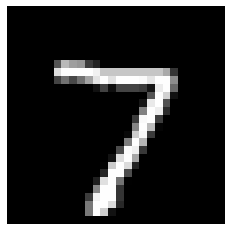

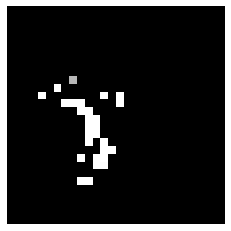

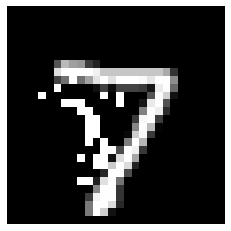

Generating adv. example for target class 9


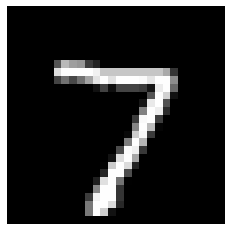

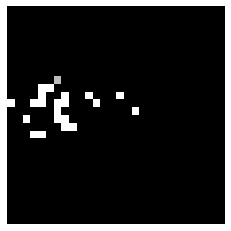

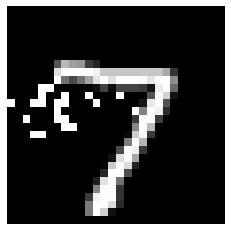

--------------------------------------
Attacking input 2/10
Generating adv. example for target class 0


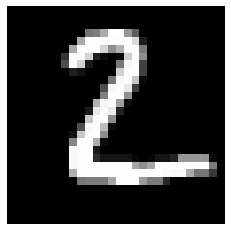

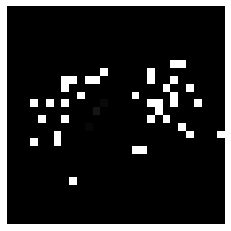

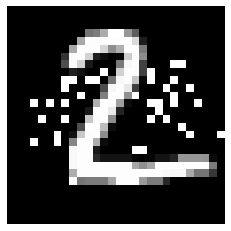

Generating adv. example for target class 1


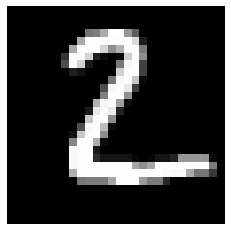

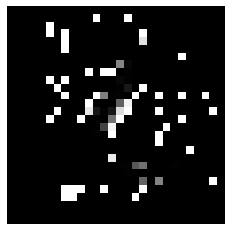

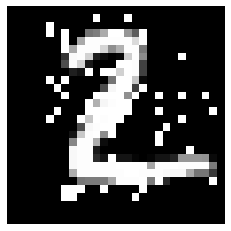

Generating adv. example for target class 3


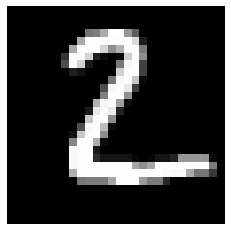

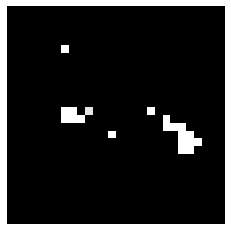

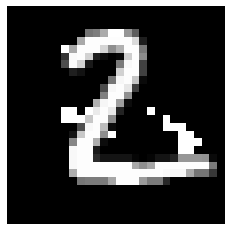

Generating adv. example for target class 4


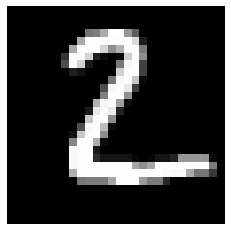

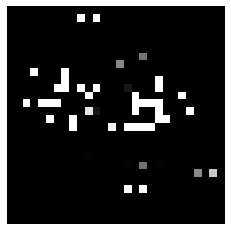

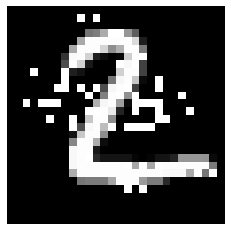

Generating adv. example for target class 5


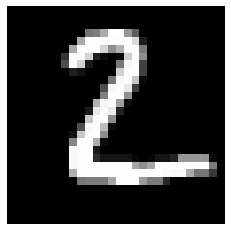

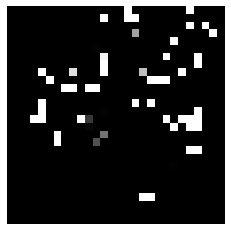

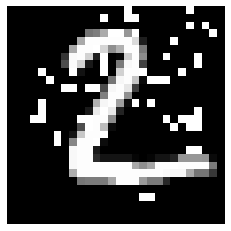

Generating adv. example for target class 6


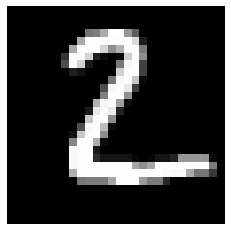

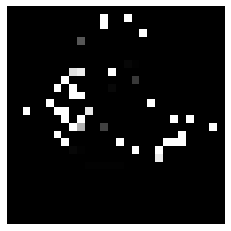

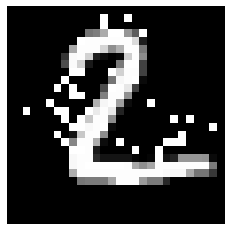

Generating adv. example for target class 7


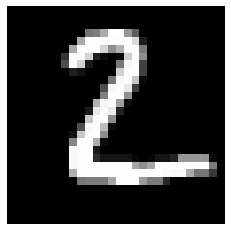

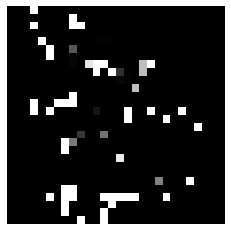

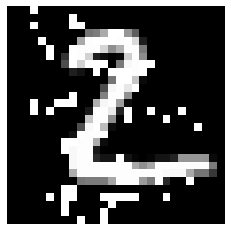

Generating adv. example for target class 8


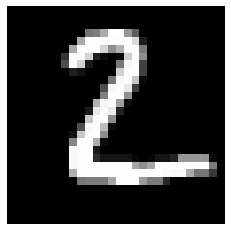

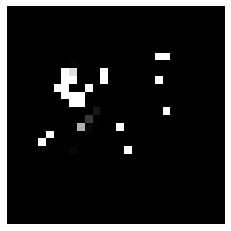

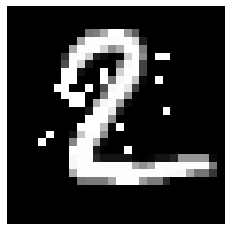

Generating adv. example for target class 9


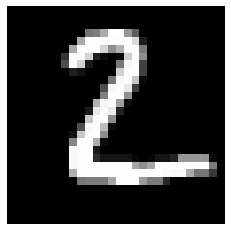

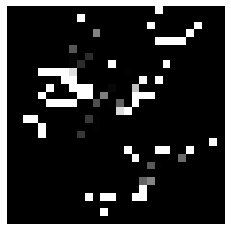

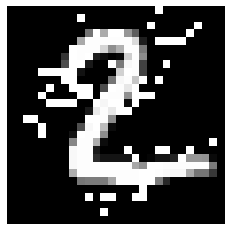

--------------------------------------
Attacking input 3/10
Generating adv. example for target class 0


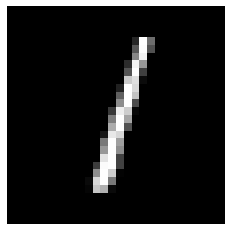

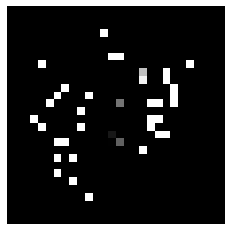

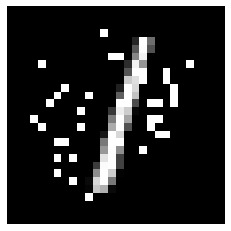

Generating adv. example for target class 2


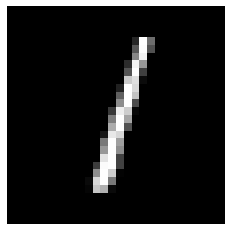

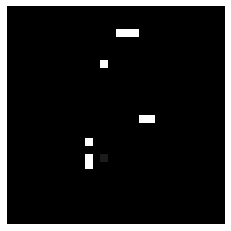

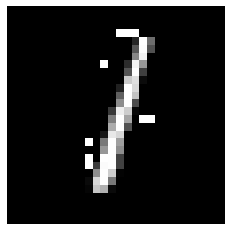

Generating adv. example for target class 3


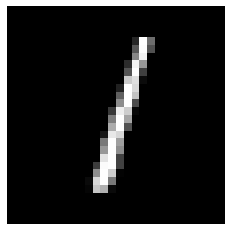

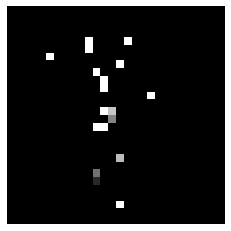

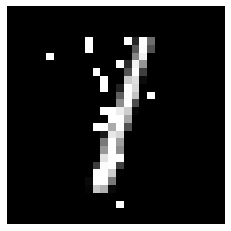

Generating adv. example for target class 4


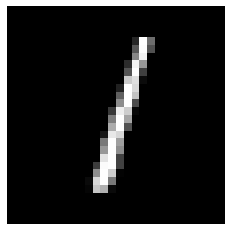

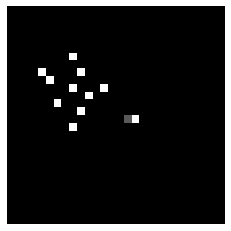

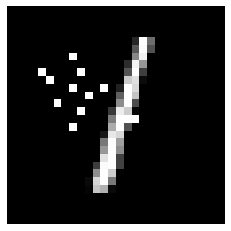

Generating adv. example for target class 5


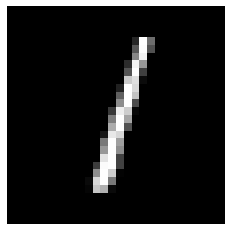

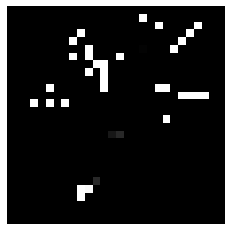

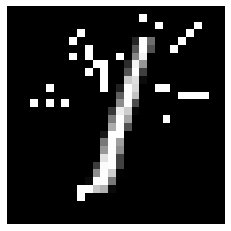

Generating adv. example for target class 6


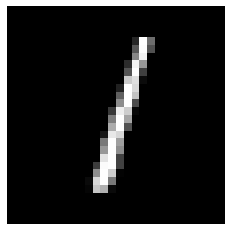

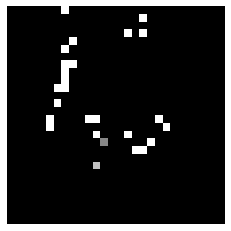

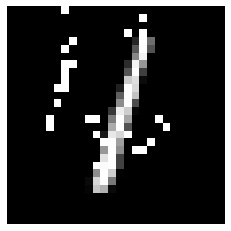

Generating adv. example for target class 7


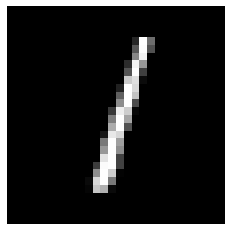

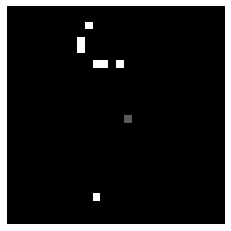

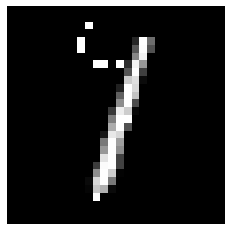

Generating adv. example for target class 8


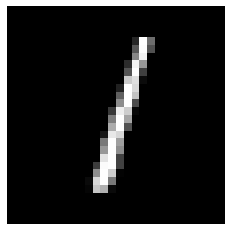

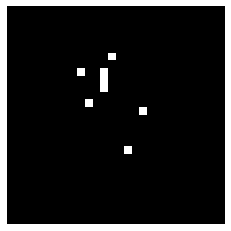

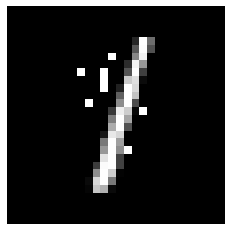

Generating adv. example for target class 9


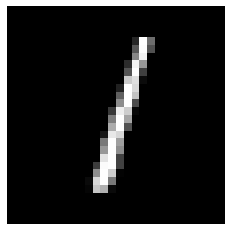

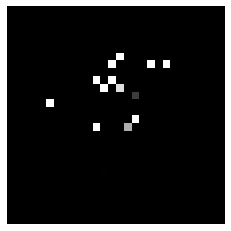

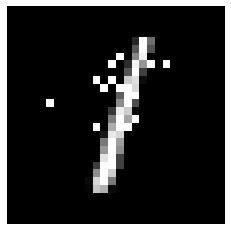

--------------------------------------
Attacking input 4/10
Generating adv. example for target class 1


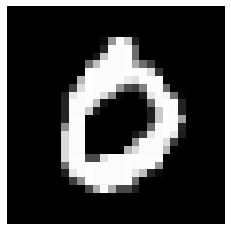

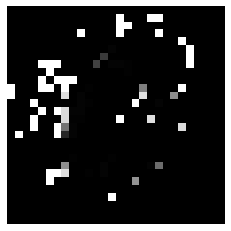

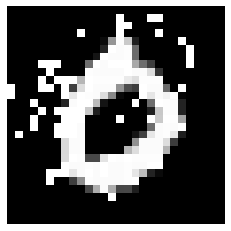

Generating adv. example for target class 2


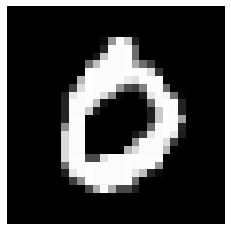

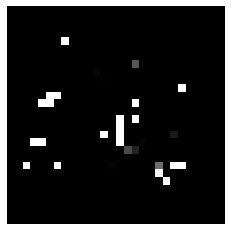

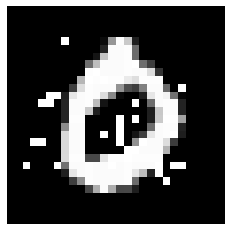

Generating adv. example for target class 3


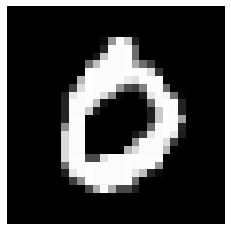

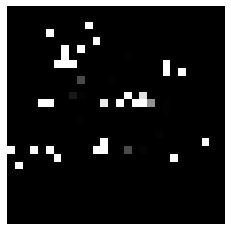

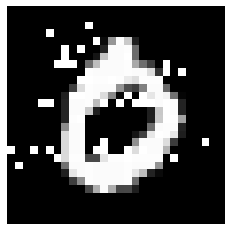

Generating adv. example for target class 4


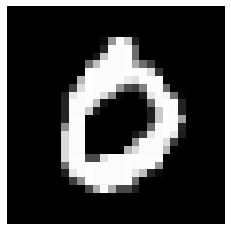

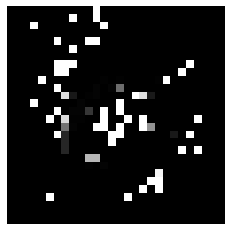

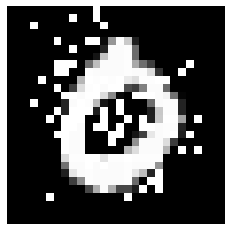

Generating adv. example for target class 5


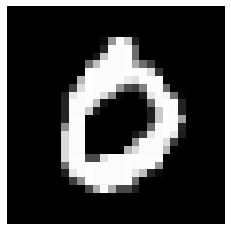

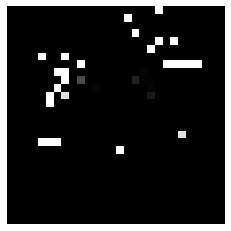

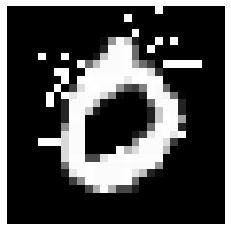

Generating adv. example for target class 6


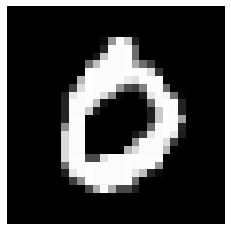

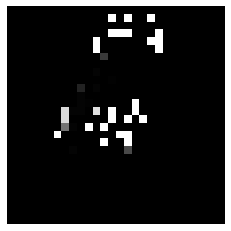

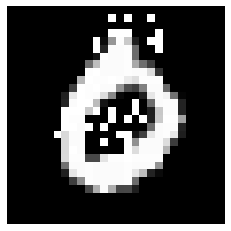

Generating adv. example for target class 7


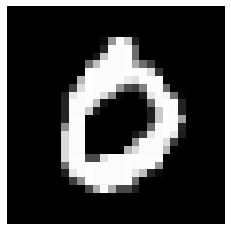

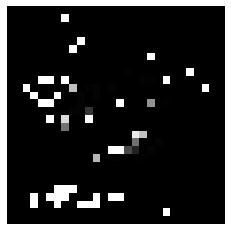

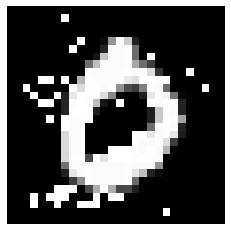

Generating adv. example for target class 8


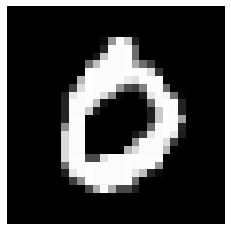

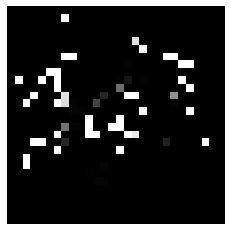

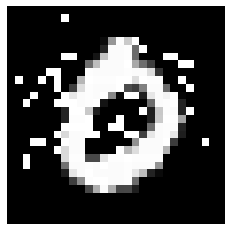

Generating adv. example for target class 9


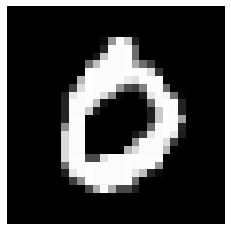

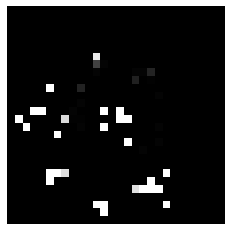

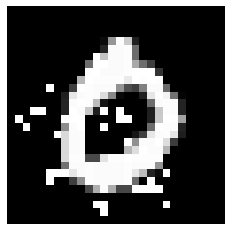

--------------------------------------
Attacking input 5/10
Generating adv. example for target class 0


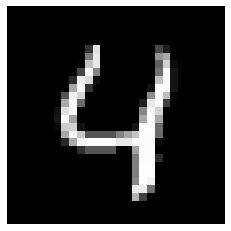

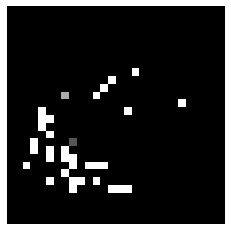

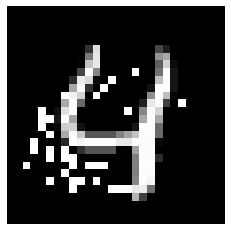

Generating adv. example for target class 1


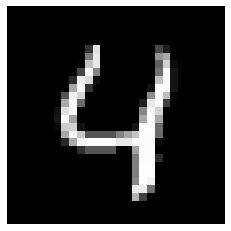

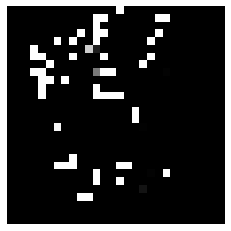

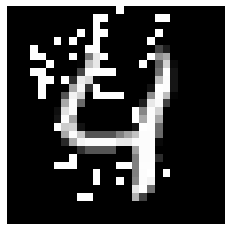

Generating adv. example for target class 2


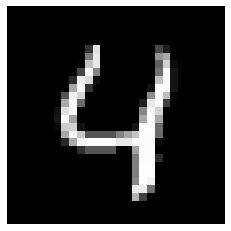

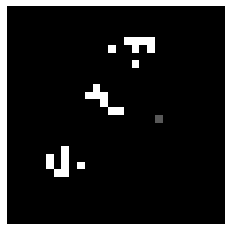

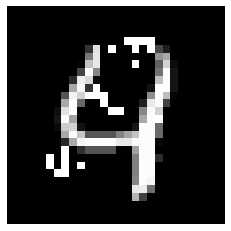

Generating adv. example for target class 3


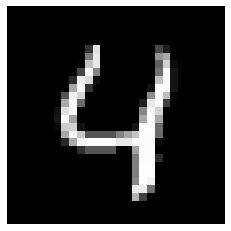

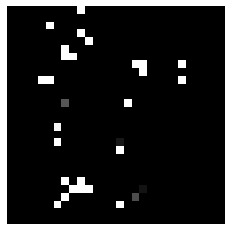

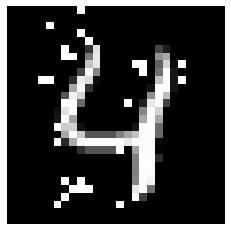

Generating adv. example for target class 5


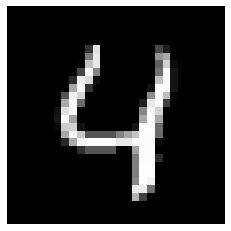

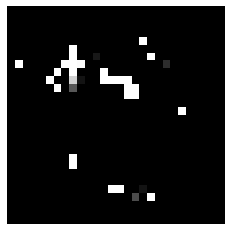

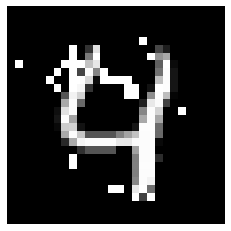

Generating adv. example for target class 6


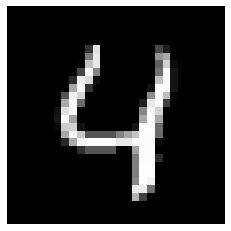

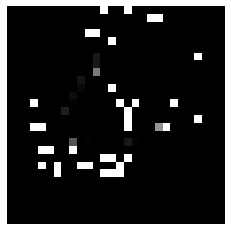

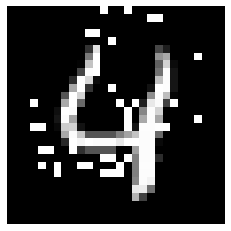

Generating adv. example for target class 7


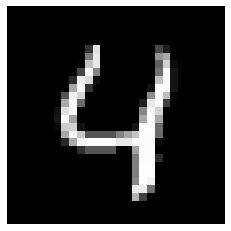

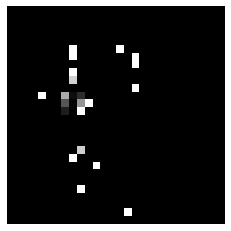

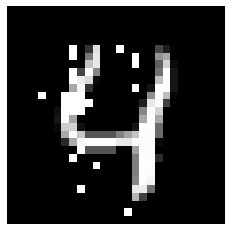

Generating adv. example for target class 8


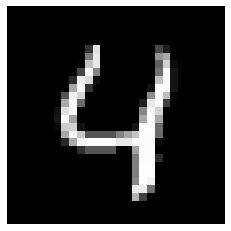

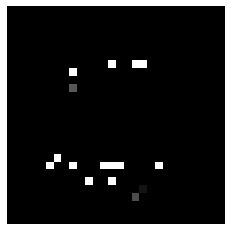

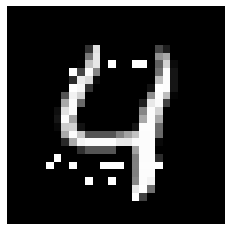

Generating adv. example for target class 9


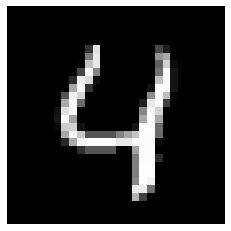

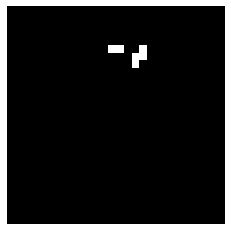

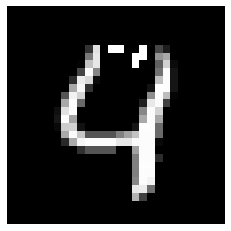

--------------------------------------
Attacking input 6/10
Generating adv. example for target class 0


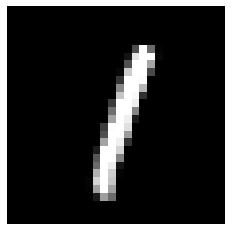

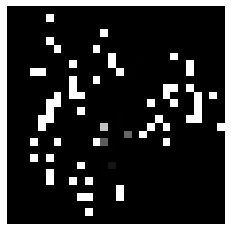

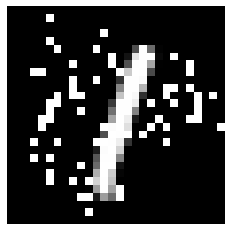

Generating adv. example for target class 2


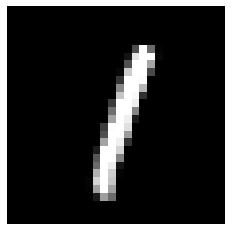

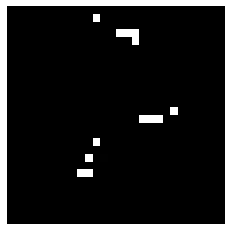

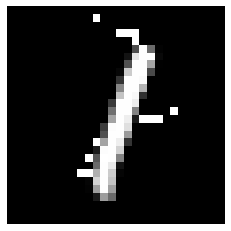

Generating adv. example for target class 3


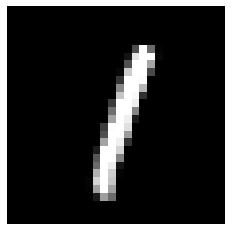

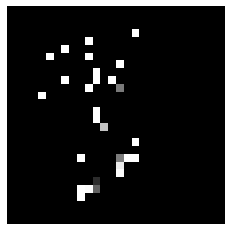

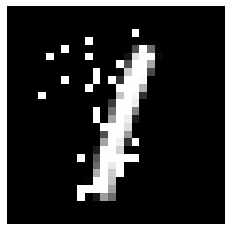

Generating adv. example for target class 4


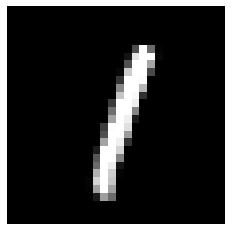

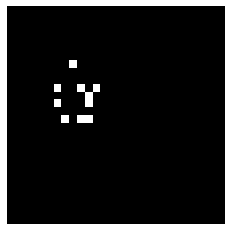

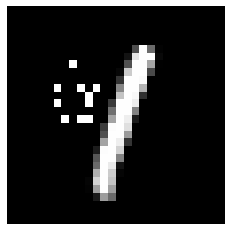

Generating adv. example for target class 5


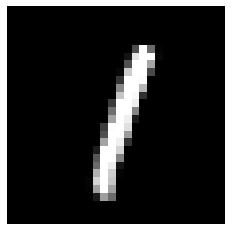

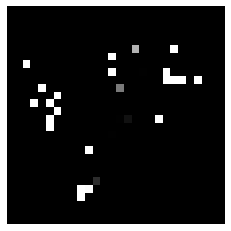

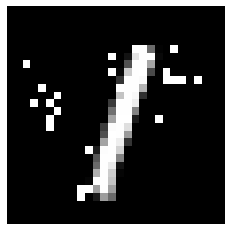

Generating adv. example for target class 6


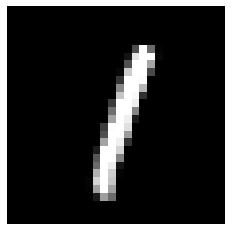

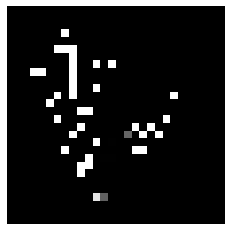

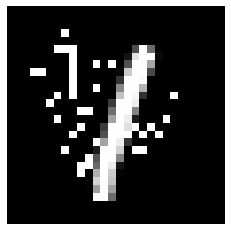

Generating adv. example for target class 7


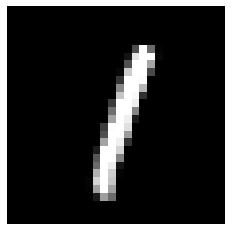

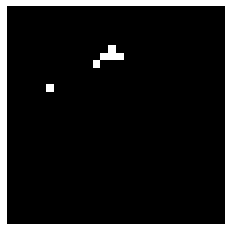

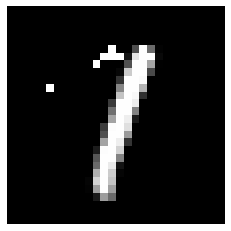

Generating adv. example for target class 8


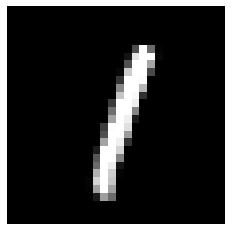

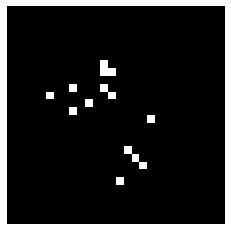

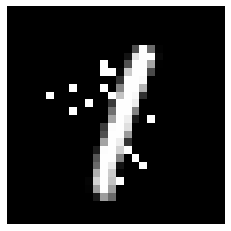

Generating adv. example for target class 9


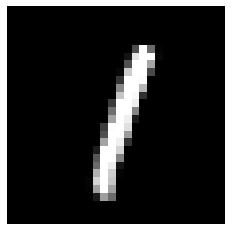

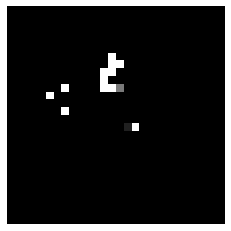

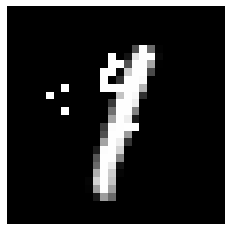

--------------------------------------
Attacking input 7/10
Generating adv. example for target class 0


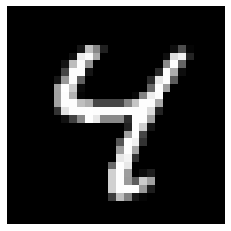

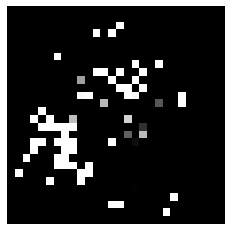

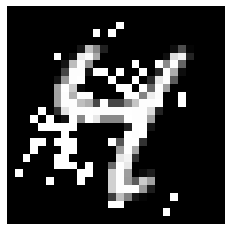

Generating adv. example for target class 1


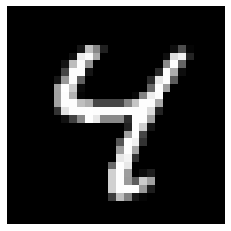

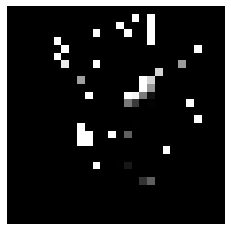

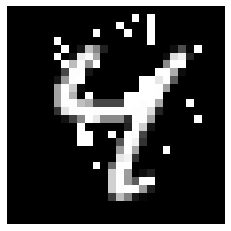

Generating adv. example for target class 2


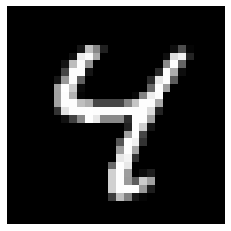

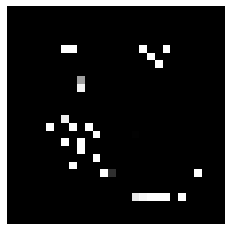

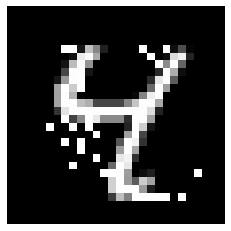

Generating adv. example for target class 3


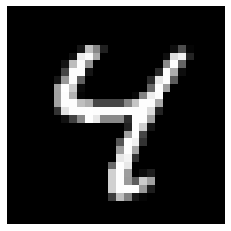

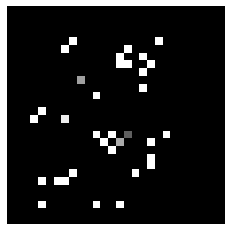

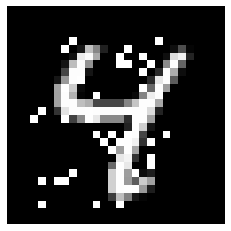

Generating adv. example for target class 5


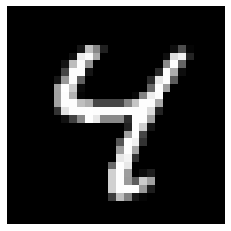

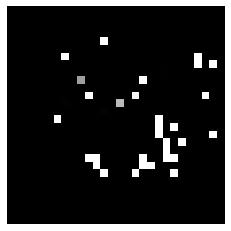

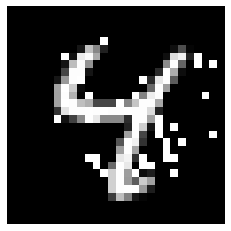

Generating adv. example for target class 6


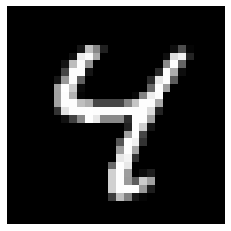

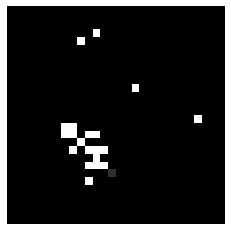

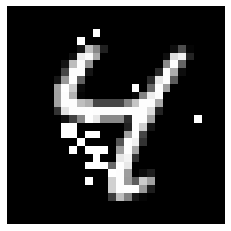

Generating adv. example for target class 7


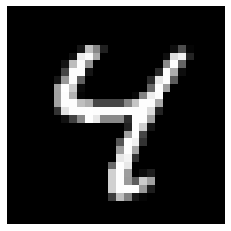

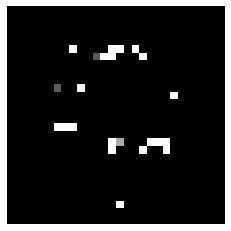

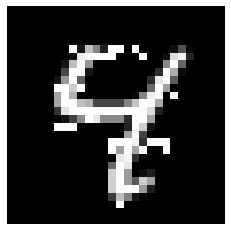

Generating adv. example for target class 8


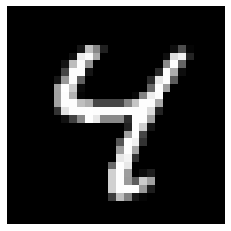

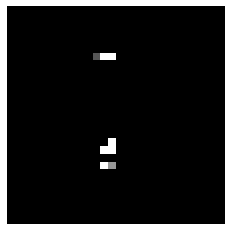

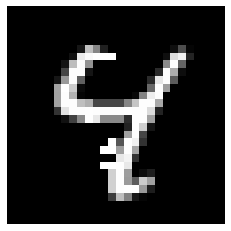

Generating adv. example for target class 9


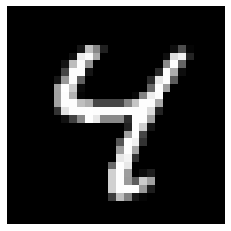

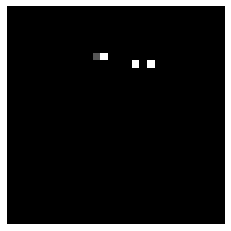

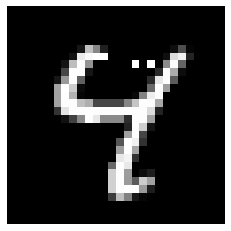

--------------------------------------
Attacking input 8/10
Generating adv. example for target class 0


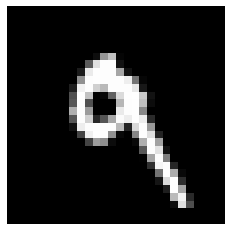

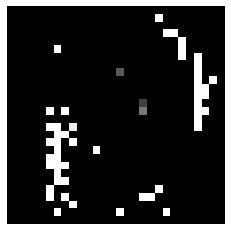

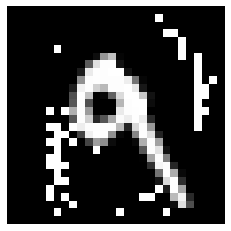

Generating adv. example for target class 1


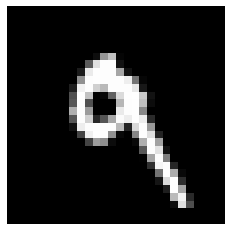

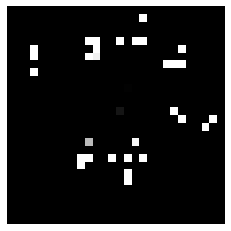

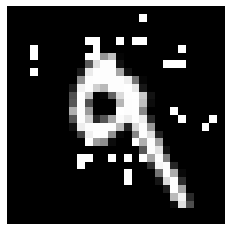

Generating adv. example for target class 2


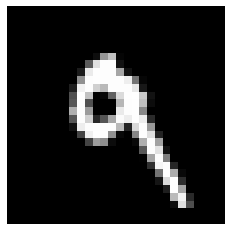

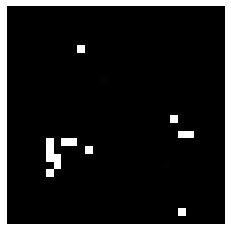

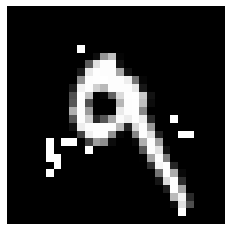

Generating adv. example for target class 3


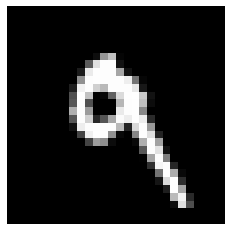

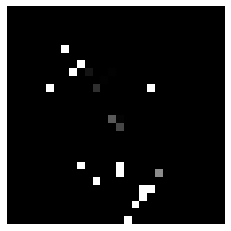

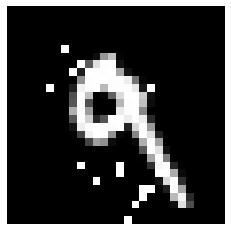

Generating adv. example for target class 4


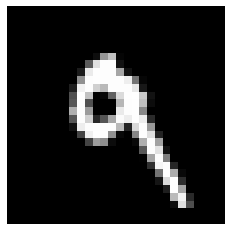

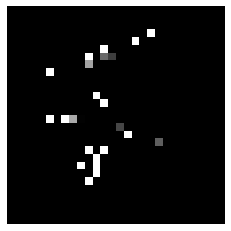

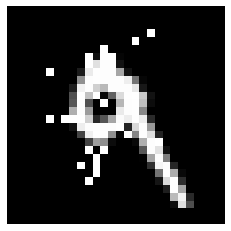

Generating adv. example for target class 5


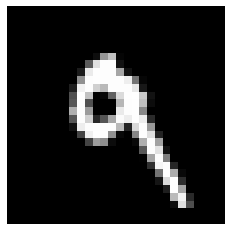

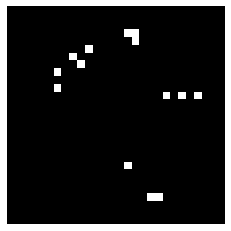

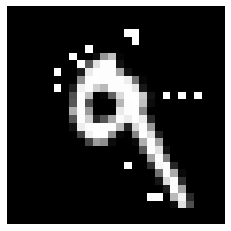

Generating adv. example for target class 6


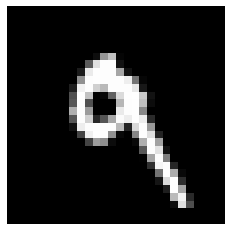

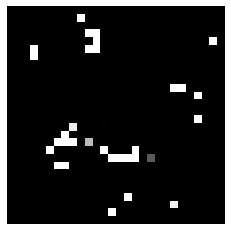

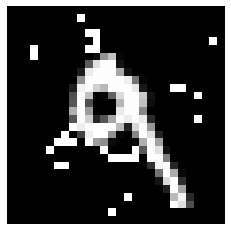

Generating adv. example for target class 7


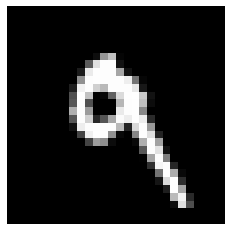

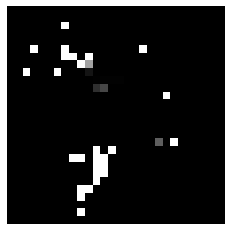

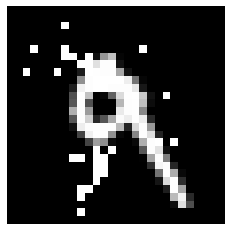

Generating adv. example for target class 8


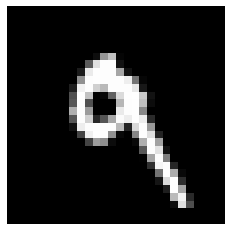

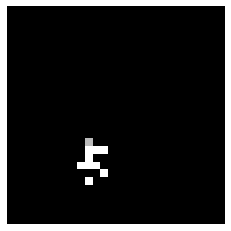

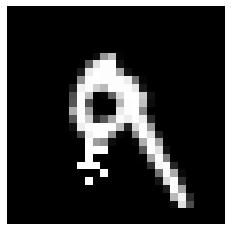

--------------------------------------
Attacking input 9/10
Generating adv. example for target class 0


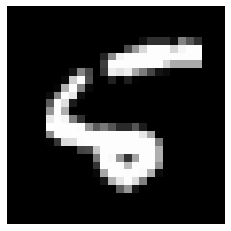

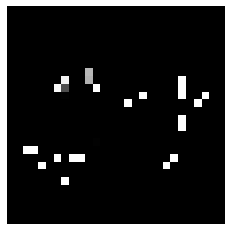

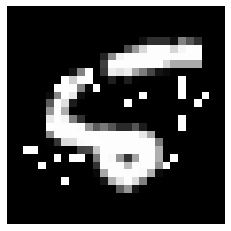

Generating adv. example for target class 1


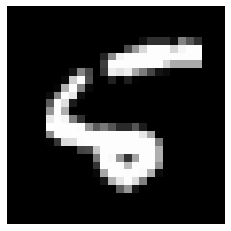

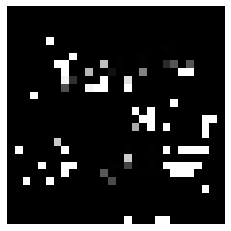

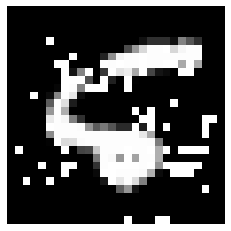

Generating adv. example for target class 2


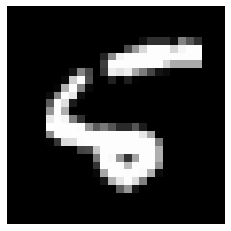

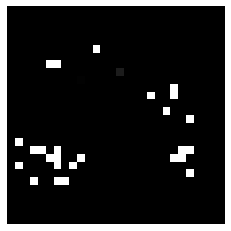

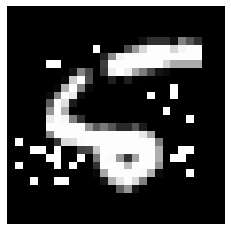

Generating adv. example for target class 3


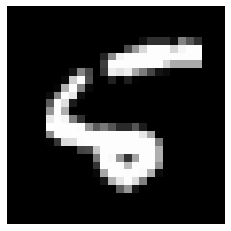

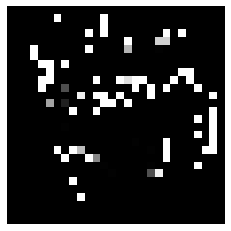

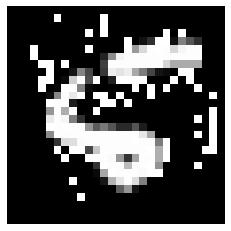

Generating adv. example for target class 4


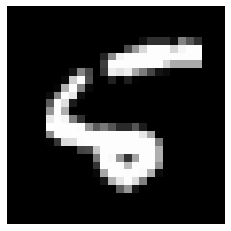

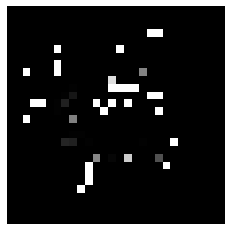

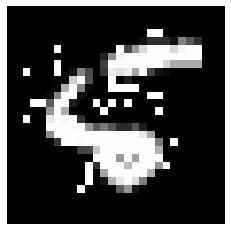

Generating adv. example for target class 6


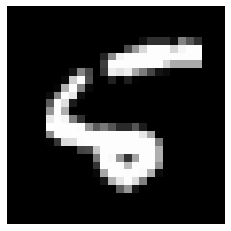

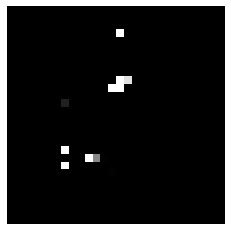

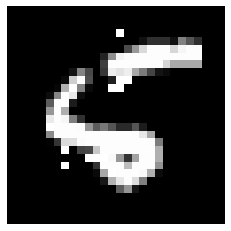

Generating adv. example for target class 7


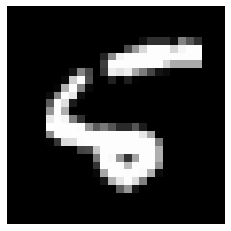

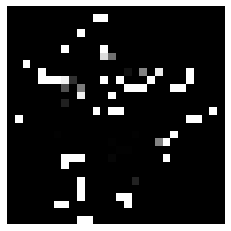

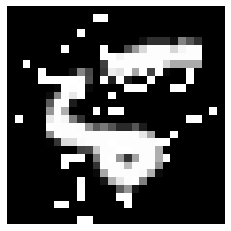

Generating adv. example for target class 8


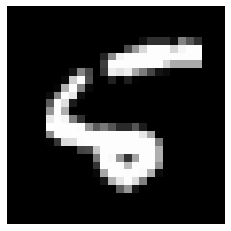

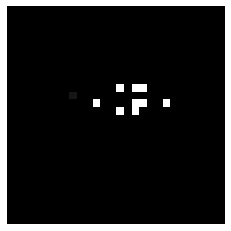

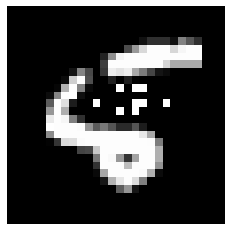

Generating adv. example for target class 9


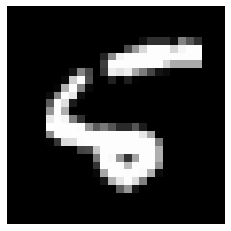

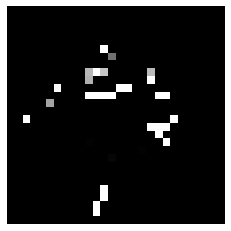

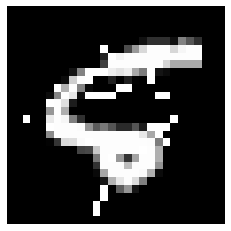

--------------------------------------
Attacking input 10/10
Generating adv. example for target class 0


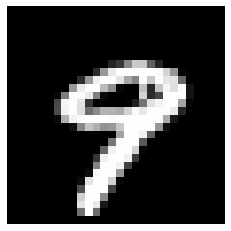

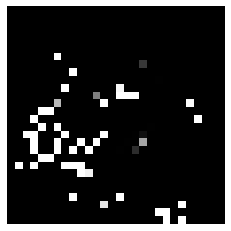

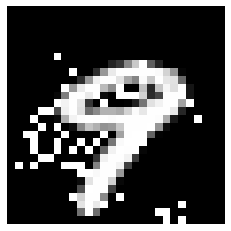

Generating adv. example for target class 1


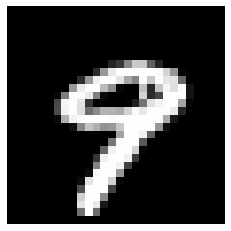

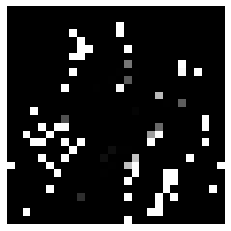

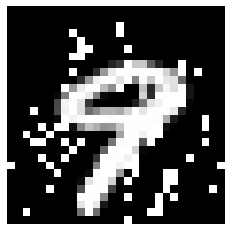

Generating adv. example for target class 2


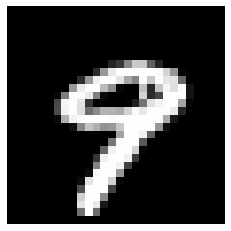

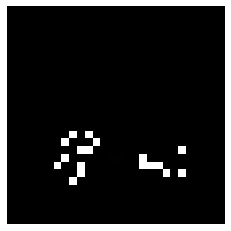

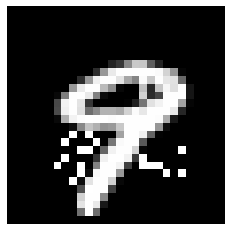

Generating adv. example for target class 3


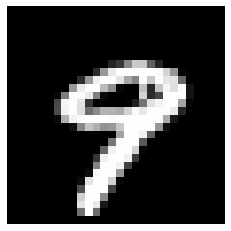

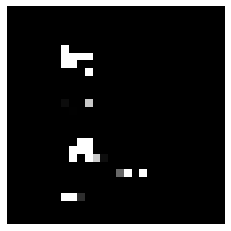

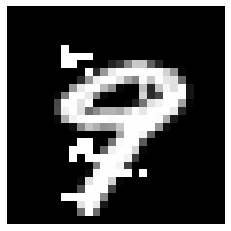

Generating adv. example for target class 4


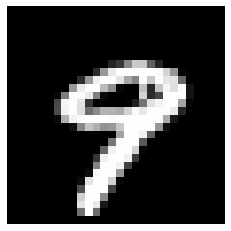

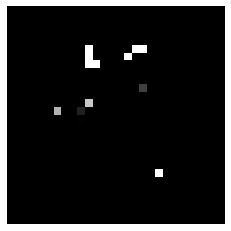

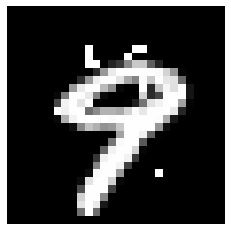

Generating adv. example for target class 5


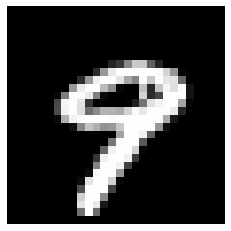

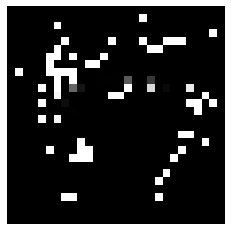

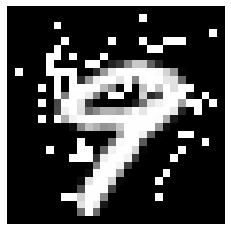

Generating adv. example for target class 6


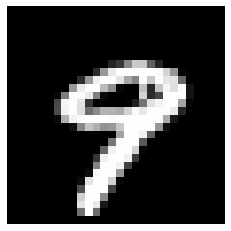

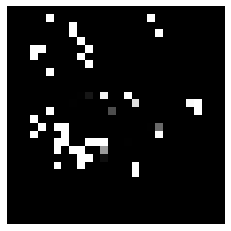

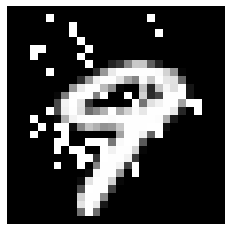

Generating adv. example for target class 7


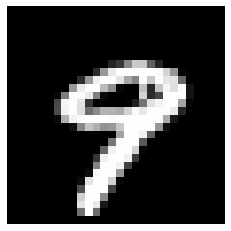

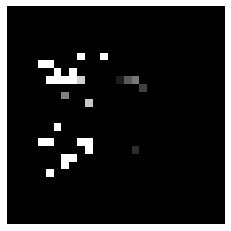

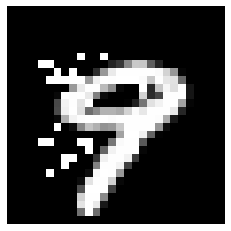

Generating adv. example for target class 8


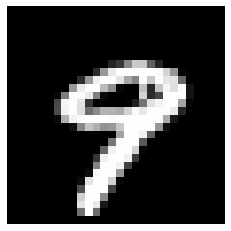

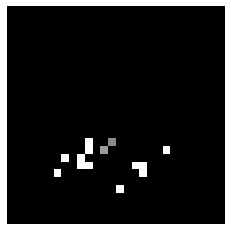

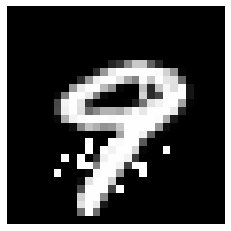

--------------------------------------
Avg. rate of successful adv. examples 0.9000
Avg. rate of perturbed features 0.0412
Avg. rate of perturbed features for successful adversarial examples 0.0322


/home/lukec/workspace/cleverhans/cleverhans/utils.py:178: UserWarning: `grid_visual` has moved to `cleverhans.plot.pyplot_image`. cleverhans.utils.grid_visual may be removed on or after 2019-04-24.
  warnings.warn("`grid_visual` has moved to `cleverhans.plot.pyplot_image`. "


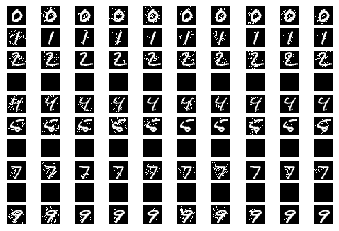

AttributeError: module '__main__' has no attribute 'main'

In [10]:
mnist_tutorial_jsma()

tf.app.run()
